difference: 
diff [-233.50114    -3.86786   -59.173755  148.325055   86.47029 ] [ 82.04521139 116.9364614   35.16077203  99.16460646  73.92451569]
diff 0.0031257687623252994
diff 0.9445919903411589
diff 0.019720392823495032
diff 0.028712901589912285
diff 0.05907447260618203
npp - npp :  ('a', 'a')
npp - rh :  ('a', 'b')
npp - ch4 :  ('a', 'b')
rh - npp :  ('a', 'b')
rh - rh :  ('a', 'a')
rh - ch4 :  ('a', 'a')
ch4 - npp :  ('a', 'b')
ch4 - rh :  ('a', 'a')
ch4 - ch4 :  ('a', 'a')
1.2324773248365881 0.5284256491718821 3.857380073180157e-05
-0.8722478828068568 0.40493414811990847 0.0006272116685716247
-0.4103237011665022 0.03743007553797062 0.35412655566036466
diff [-222.96159  -183.118255 -199.49895   -13.053975 -146.592745] [59.92649362 28.63836937 46.67203025 78.00782654 58.42361352]
diff [  20.09944 -154.41142  -50.11284 -160.8639  -135.89426] [ 60.92831247  79.02496375  81.03666367 100.30155156 140.71092341]
diff [  4.81142 -26.69434 -88.45586   0.75142 -86.67824] [19.17555105 11.18

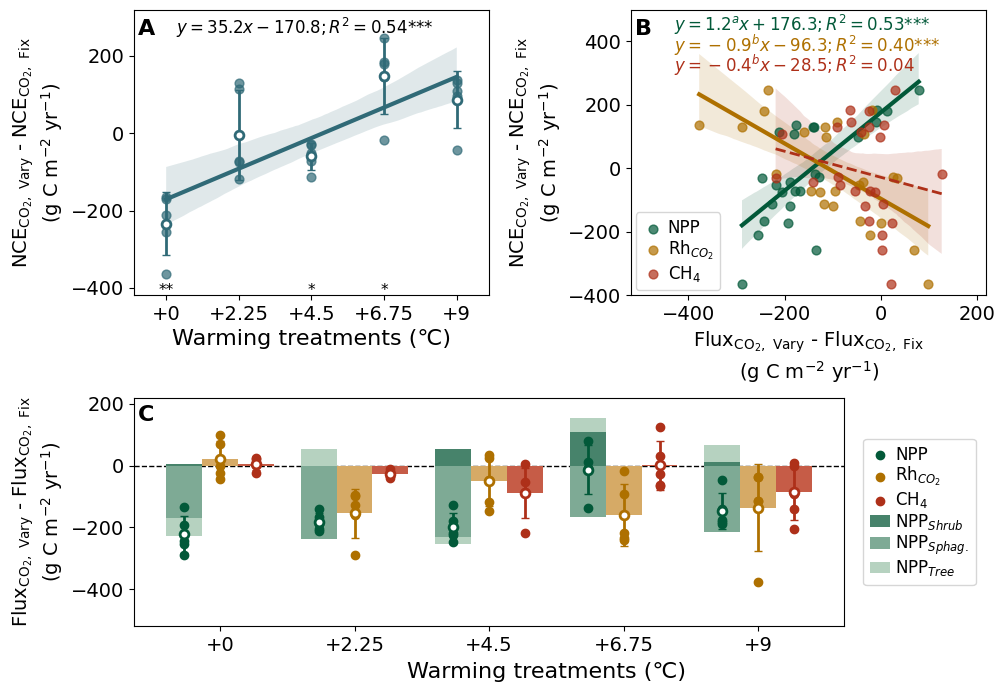

In [7]:
# NCE; NEC difference between with and without community structure changes; explain why?
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress, ttest_1samp
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm
import statsmodels.formula.api as smf
def cal_reg_diff(x_ambient, y_ambient, x_elevated, y_elevated):
    """
    Fits y ~ x + group + x:C(group) and returns the p-values for
    differences in slope and intercept between the two groups.  If only
    one group is present the p-values will be None.
    """
    # Create a DataFrame with a categorical group column
    x = np.concatenate([x_ambient, x_elevated])
    y = np.concatenate([y_ambient, y_elevated])
    group_labels = (['ambient'] * len(x_ambient)) + (['elevated'] * len(x_elevated))
    df = pd.DataFrame({'y': y, 'x': x, 'group': group_labels})
    df['group'] = df['group'].astype('category')

    # Fit the model
    model = smf.ols('y ~ x + group + x:C(group)', data=df).fit()

    # Dynamically extract p‑values for group effects
    slope_pval = None
    intercept_pval = None
    for term, pval in model.pvalues.items():
        if term.startswith('x:C(group)'):
            slope_pval = pval
        elif term.startswith('C(group)'):
            intercept_pval = pval

    # slope_pval and intercept_pval will be None if there is only one group
    if slope_pval is not None and slope_pval < 0.05:
        res_ab_slope = ('a', 'b')
    else:
        res_ab_slope = ('a', 'a')

    if intercept_pval is not None and intercept_pval < 0.05:
        res_ab_intercept = ('a', 'b')
    else:
        res_ab_intercept = ('a', 'a')

    return res_ab_slope, res_ab_intercept

df_data_co2   = pd.read_excel("1_data_minus_2013.xlsx")
df_data_noacc = pd.read_excel("1_data_noacc_minus_2013.xlsx")

df_data_co2 = df_data_co2[df_data_co2["year"]>2016]
df_data_noacc = df_data_noacc[df_data_noacc["year"]>2016]

df_data_co2['nce'] = (df_data_co2["gpp_Tree"] + df_data_co2["gpp_Shrub"] + df_data_co2["gpp_Sphagnum"] - 
                (df_data_co2["ra_Tree"] + df_data_co2["ra_Shrub"] + df_data_co2["ra_Sphagnum"]) - 
                df_data_co2["rh"] - df_data_co2["ch4"])

df_data_co2["npp"] = df_data_co2["npp_Tree"] + df_data_co2["npp_Shrub"] + df_data_co2["npp_Sphagnum"]

df_data_noacc['nce'] = (df_data_noacc["gpp_Tree"] + df_data_noacc["gpp_Shrub"] + df_data_noacc["gpp_Sphagnum"] - 
                (df_data_noacc["ra_Tree"] + df_data_noacc["ra_Shrub"] + df_data_noacc["ra_Sphagnum"]) - 
                df_data_noacc["rh"] - df_data_noacc["ch4"])

# df_data_co2["rh"] = - df_data_co2["rh"]
# df_data_co2["ch4"] = -df_data_co2["ch4"]
# df_data_noacc["rh"] = -df_data_noacc["rh"]
# df_data_noacc["ch4"] = -df_data_noacc["ch4"]

def cal_diff(df_acc, df_noacc, ivar):
    ls_cols  = ["year", "warming", "co2", ivar]
    df_merge = pd.merge(df_acc[ls_cols], df_noacc[ls_cols], on=["year", "warming", "co2"], how="outer").rename(columns={f"{ivar}_x":"acc", f"{ivar}_y":"noacc"})

    df_aco2 = df_merge[df_merge["co2"]==0].copy()
    df_eco2 = df_merge[df_merge["co2"]==500].copy()

    df_co2  = pd.merge(df_aco2, df_eco2, on=["year", "warming"], how="outer")
    df_co2["acc"] = df_co2["acc_y"] - df_co2["acc_x"]
    df_co2["noacc"] = df_co2["noacc_y"] - df_co2["noacc_x"]

    df_diff = df_co2[["year", "warming", "acc", "noacc"]]
    df_diff["diff"] = df_diff["acc"] - df_diff["noacc"]
    return df_diff

def ax_plot(df_dat4plt, ivar, ax, ylim, color, nvar, eq_pos, label, color_w, mark_ornot, draw_line):
    x = df_dat4plt["warming"].values
    y = df_dat4plt[ivar].values

    df_data = df_dat4plt[["warming", ivar]].copy()
    df_data_mean = df_data.groupby("warming").agg(["mean", "std"]).reset_index()
    df_data_mean.columns = ["warming", "mean", "std"]
    print(ivar, df_data_mean["mean"].values, df_data_mean["std"].values)
    ax.errorbar(df_data_mean["warming"], df_data_mean["mean"], yerr=df_data_mean["std"], fmt='none', color=color, capsize=3, linewidth=2, zorder=1)
    ax.scatter(df_data_mean["warming"], df_data_mean["mean"], marker='o', s=40, 
                color='white', edgecolor=color, linewidth=2, zorder=3)
    
    if draw_line: 
        slope, intercept, r, p, stderr = linregress(x, y)
        line_style = "-" if p < 0.05 else "--"
        line_width = 3 if p<0.05 else 2
        mark_p = ""
        if p < 0.001:
            mark_p = "***"
        elif p<0.01:
            mark_p = "**"
        elif p <0.05:
            mark_p = "*"
        sns.regplot(x=x, y=y, ax=ax, scatter_kws={"zorder": 2, "s": 40, "alpha": 0.7, "color": color},
            line_kws={"zorder": 2, "color": color, "lw": line_width, "linestyle": line_style}, label=label)
        if intercept < 0:
            equation = f"$y={slope:.1f}x - {-intercept:.1f}; R^2={r*r:.2f}$"+mark_p#(rf"$^{{{mark_p}}}$" if mark_p else "")
        else:
            equation = f"$y={slope:.1f}x + {intercept:.1f}; R^2={r*r:.2f}$"+mark_p#(rf"$^{{{mark_p}}}$" if mark_p else "")
        # if r*r < 0.01:
        #     equation = f"Slope = {slope:.1f}; R$^2$<0.01" +(rf"$^{{{mark_p}}}$" if mark_p else "")
        # else:
        #     equation = f"Slope = {slope:.1f}; R$^2$={r*r:.2f}" +(rf"$^{{{mark_p}}}$" if mark_p else "")

        ax.text(eq_pos[0], eq_pos[1], equation, color=color_w,
                ha="left", va="top", fontsize=12, transform=ax.transAxes)
    else:
        ax.scatter(x=x, y=y, color=color, label=label)
    # ---- t-test
    if mark_ornot:
        for idx_warming, iwarm in enumerate(df_data["warming"].unique()):
            diff_data  = df_data[df_data["warming"]==iwarm][ivar].values
            # _, p_value = ttest_1samp(diff_data, 0)
            _, p_value = ttest_1samp(diff_data, popmean=0)
            print(ivar, p_value)
            if p_value < 0.05:
                marker = '*' if p_value < 0.05 else ''
                marker = '**' if p_value < 0.01 else marker
                marker = '***' if p_value < 0.001 else marker
                ax.text(iwarm, ylim[0] + 0.017*(ylim[1]-ylim[0])*(1+nvar*1.3), 
                        marker, ha='center', va='center', fontsize=11, color=color_w)
    ax.set_ylim(ylim) 

# fig, axes = plt.subplots(2,2,figsize=(11,8), sharex=True)
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(11,8))

gs = gridspec.GridSpec(2, 2, height_ratios=[1,0.8], width_ratios=[1, 1], wspace=0.4, hspace=0.4)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])

gs_low = gs[1,:].subgridspec(1, 2, width_ratios=[0.5,0.1], wspace=0)
ax_big = fig.add_subplot(gs_low[0,0])

# # NCE and its difference
# ax = ax1#axes[0,0]
df_nce = cal_diff(df_data_co2, df_data_noacc, "nce")
# ax_plot(df_nce, "noacc", ax, (-149,199), "#306A77", 0, (0.12, 0.98), "NCE", "k", True, True)
# ax.set_ylabel("CO$_2$ effect on NCE$_{Fix}$\n(g C m$^{-2}$ yr$^{-1}$)", fontsize=14)
# ---------------------------------------------------------------
# differences between with and without 
print("difference: ")
ax = ax1 #axes[0,1]
ax_plot(df_nce, "diff", ax, (-419,319),"#306A77", 0, (0.12, 0.98), "NCE", "k", True, True)
ylabel =  r"NCE$_{\mathrm{CO_2,\ Vary}}$ - "+r"NCE$_{\mathrm{CO_2,\ Fix}}$"+"\n(g C m$^{-2}$ yr$^{-1}$)"
ax.set_ylabel(ylabel, fontsize=14)
# print("end difference")

# relationship between NPP, Rh, CH4 and NCE
ax = ax2
df_nce          = cal_diff(df_data_co2, df_data_noacc, "nce")
df_npp          = cal_diff(df_data_co2, df_data_noacc, "npp")
df_rh           = cal_diff(df_data_co2, df_data_noacc, "rh")
df_ch4          = cal_diff(df_data_co2, df_data_noacc, "ch4")
df_NPP_shrub    = cal_diff(df_data_co2, df_data_noacc, "npp_Shrub")
df_NPP_sphagnum = cal_diff(df_data_co2, df_data_noacc, "npp_Sphagnum")
df_NPP_tree     = cal_diff(df_data_co2, df_data_noacc, "npp_Tree")

dict_colors = {
    "gpp": "#214EA7", "ra": "#F38B2F", "npp": "#025939", "rh": "#AE7000", "ch4":"#AE3019",
    "npp_Shrub":"#d95f02", "npp_Sphagnum":  "#7570b3", "npp_Tree": "#377eb8"}

dict_data = {
    "npp":df_npp, "rh": df_rh, "ch4": df_ch4, "npp_Shrub": df_NPP_shrub, "npp_Sphagnum":df_NPP_sphagnum, "npp_Tree": df_NPP_tree
}

dict_pos = {
    "npp":(0.12, 0.99), "rh": (0.12, 0.92), "ch4": (0.12, 0.85), "npp_Shrub": (0.12, 0.99), "npp_Sphagnum":(0.48, 0.16), "npp_Tree": (0.48, 0.08)
}

dict_labels = {
    "npp":"NPP", "rh": "Rh$_{CO_2}$", "ch4": "CH$_4$", "npp_Shrub": "NPP$_{Shrub}$", "npp_Sphagnum":"NPP$_{Sphag.}$", "npp_Tree": "NPP$_{Tree}$"
}

for ivar in ["npp", "rh", "ch4"]:
    df_dat4plt = dict_data[ivar]
    df_merge = df_dat4plt.merge(df_nce, on=["year", "warming"], how="outer")
    x_ivar = df_merge["diff_x"].values
    y_ivar = df_merge["diff_y"].values
    for jvar in ["npp", "rh", "ch4"]:
        df_dat4plt = dict_data[jvar]
        df_merge = df_dat4plt.merge(df_nce, on=["year", "warming"], how="outer")
        x_jvar = df_merge["diff_x"].values
        y_jvar = df_merge["diff_y"].values
        res_ab_slope, res_ab_intercept = cal_reg_diff(x_ivar, y_ivar, x_jvar, y_jvar)
        print(ivar, "-", jvar, ": ", res_ab_slope )
slope_mark = ["a", "b", "b"]
for idx_var, ivar in enumerate(["npp", "rh", "ch4"]):
    df_dat4plt = dict_data[ivar]
    color = dict_colors[ivar] 
    df_merge = df_dat4plt.merge(df_nce, on=["year", "warming"], how="outer")
    x = df_merge["diff_x"].values
    y = df_merge["diff_y"].values
    slope, intercept, r, p, stderr = linregress(x, y)
    line_style = "-" if p < 0.05 else "--"
    line_width = 3 if p<0.05 else 2
    print(slope, r*r, p)
    mark_p = ""
    if p < 0.001:
        mark_p = "***"
    elif p<0.01:
        mark_p = "**"
    elif p <0.05:
        mark_p = "*"
    sns.regplot(x=x, y=y, ax=ax, scatter_kws={"zorder": 2, "s": 40, "alpha": 0.7, "color": color},
        line_kws={"zorder": 2, "color": color, "lw": line_width, "linestyle": line_style}, label=dict_labels[ivar])
    # --------------------------------------------
    # equation = f"Slope = {slope:.1f}; R$^2$={r*r:.2f}" +(rf"$^{{{mark_p}}}$" if mark_p else "")
    if intercept < 0:
        equation = f"$y={slope:.1f}^{slope_mark[idx_var]}x - {-intercept:.1f}; R^2={r*r:.2f}$"+mark_p#(rf"$^{{{mark_p}}}$" if mark_p else "")
    else:
        equation = f"$y={slope:.1f}^{slope_mark[idx_var]}x + {intercept:.1f}; R^2={r*r:.2f}$"+mark_p#(rf"$^{{{mark_p}}}$" if mark_p else "")
    ax.text(dict_pos[ivar][0], dict_pos[ivar][1], equation, color=color,
            ha="left", va="top", fontsize=12, transform=ax.transAxes)
# -----------------------------
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ylabel =  r"NCE$_{\mathrm{CO_2,\ Vary}}$ - "+ r"NCE$_{\mathrm{CO_2,\ Fix}}$"+"\n(g C m$^{-2}$ yr$^{-1}$)"
ax.set_ylabel(ylabel, fontsize=14)

xlabel = r"Flux$_{\mathrm{CO_2,\ Vary}}$ - "+ r"Flux$_{\mathrm{CO_2,\ Fix}}$"+"\n(g C m$^{-2}$ yr$^{-1}$)"
ax.set_xlabel(xlabel, fontsize=14)


# ---------------------------------------------------------------
ax = ax_big#axes[1,0]

ls_warmings = [0, 2.25, 4.5, 6.75, 9]
categories = ["npp", "rh", "ch4"]
n_warmings = len(ls_warmings)

# dict_vars = {"npp": ["npp_Shrub","npp_Sphagnum", "npp_Tree"],
#              "rh":  ["rh_lit", "rh_soil"], "ch4": ["ch4"]}

dict_vars = {"npp": ["npp_Shrub","npp_Sphagnum", "npp_Tree"],
             "rh":  ["rh"], "ch4": ["ch4"]}

# dict_colors = {
#     "gpp": "#214EA7", "ra": "#F38B2F", "npp": "#025939", "rh": "#AE7000", "ch4":"#AE3019",# CC9966 "#5C4033"#"#7e5e9b"#"#6b6b6b"
#     "npp_Shrub":"#d95f02", "npp_Sphagnum": "#7570b3", "npp_Tree": "#377eb8", "rh_lit":  "#AE7000", "rh_soil": "#F38B2F"
# }

dict_colors = {
    "npp_Shrub":"#47836b", "npp_Sphagnum": "#7eaa95", "npp_Tree": "#b6d2c0", 
    "rh_lit":  "#c68c33", "rh_soil": "#d6aa66", "ch4": "#c65c47", "rh": "#d6aa66"
}

bar_width = 0.6
x = np.arange(n_warmings)

dict_labels = {"npp_Shrub": "NPP$_{Shrub}$","npp_Sphagnum": "NPP$_{Sphag.}$", "npp_Tree":"NPP$_{Tree}$",
               "rh_lit": "Rh$_{CO_2,Litter}$", "rh_soil":"Rh$_{CO_2,Soil}$", "ch4": "CH$_4$",
               "rh": "Rh$_{CO_2}$"}
# for idx_flux, iflux in enumerate()

for idx_flux, iflux in enumerate(categories):
    xpos = np.array(ls_warmings) + (idx_flux - 1) * bar_width
    
    bottom_pos = np.zeros(n_warmings)
    bottom_neg = np.zeros(n_warmings)
    
    # for j in range(data.shape[2]): 
    for idx_var, ivar in enumerate(dict_vars[iflux]):
        df_values = cal_diff(df_data_co2, df_data_noacc, ivar)
        values = df_values.groupby("warming")["diff"].mean().reset_index()["diff"].values

        ax.bar(xpos, np.where(values>0, values, 0), 
               bar_width, bottom=bottom_pos, color=dict_colors[ivar], label= dict_labels[ivar])
        bottom_pos += np.where(values>0, values, 0)
        
        ax.bar(xpos, np.where(values<0, values, 0), 
               bar_width, bottom=bottom_neg, color=dict_colors[ivar], label= dict_labels[ivar])
        bottom_neg += np.where(values<0, values, 0)
# ---------------------------------------------------------------
# NPP, Rh, CH4
ax = ax_big #axes[1,0]
ax_big.axhline(y=0, color='k', linestyle='--', linewidth=1, zorder=0)
ls_pox_w = [-bar_width, 0, bar_width]
dict_colors = {
    "gpp": "#214EA7", "ra": "#F38B2F", "npp": "#025939", "rh": "#AE7000", "ch4":"#AE3019"# CC9966 "#5C4033"#"#7e5e9b"#"#6b6b6b"
}
ls_equ_pos=[(0.12, 0.99), (0.12, 0.91), (0.12, 0.83)]
ls_labels = ["NPP", "Rh$_{CO_2}$", "CH$_4$"]
for idx_var, ivar in enumerate(["npp","rh", "ch4"]):
    df_dat4plt = cal_diff(df_data_co2, df_data_noacc, ivar)
    df_dat4plt["warming"] = df_dat4plt["warming"] + ls_pox_w[idx_var]
    # if ivar == "rh": 
    values = df_dat4plt.groupby("warming")["diff"].mean().reset_index()["diff"].values
    # print(ivar, values)
    ax_plot(df_dat4plt, "diff", ax, (-519, 219), dict_colors[ivar], idx_var, ls_equ_pos[idx_var], ls_labels[idx_var], dict_colors[ivar], False, False)
ylabel = r"Flux$_{\mathrm{CO_2,\ Vary}}$ - "+ r"Flux$_{\mathrm{CO_2,\ Fix}}$"+"\n(g C m$^{-2}$ yr$^{-1}$)"
ax.set_ylabel(ylabel, fontsize=14)
# ---------------------------------------------------------------
custom_x_ticks  = [0,      2.25,    4.5,    6.75,    9]  # x stick
custom_x_labels = ['+0', '+2.25', '+4.5', '+6.75', '+9']
ls_subtitles = ["(a)", "(b)", "(c)", "(d)"]

# --------------------
ax2.set_xlim(-519, 219)
ax2.set_ylim(-400, 499)
ax2.legend(loc="lower left", ncol=1,
            # bbox_to_anchor=(0.99, 0.7),
            labelspacing=0.1, 
            columnspacing=0.5,
            handlelength=1.2,
            handletextpad=0.3,
            borderaxespad=0.3,
            fontsize = 12
    )
handles, labels = ax_big.get_legend_handles_labels()

new_order = [0, 1, 2, 3, 5, 7]#, 9, 11]  # 对应 handles/labels 的索引
cols_idx = [[0, 3, 5, 7], [1, 9, 11], [2, 13]]
new_handles = [handles[i] for i in new_order]
new_labels = [labels[i] for i in new_order]
# new_handles = []
# new_labels = []

ax_big.legend(new_handles, new_labels, ncol=1, loc='center left',
              bbox_to_anchor=(1.02, 0.5),
              labelspacing=0.1, 
            columnspacing=0.5,
            handlelength=1.2,
            handletextpad=0.3,
            borderaxespad=0.3,
            fontsize = 12)

# ---------------------------------------------------------------
custom_x_ticks  = [0,      2.25,    4.5,    6.75,    9]  # x stick
custom_x_labels = ['+0', '+2.25', '+4.5', '+6.75', '+9']
ls_subtitles = ["A", "B", "C", "D"]
for idx_ax, ax in enumerate([ax1, ax2]):
    ax.text(0.01, 0.97, ls_subtitles[idx_ax], va="top", ha="left", transform=ax.transAxes, fontsize=16, fontweight="bold")
    # ax.tick_params(axis='x', labelsize=12)
    # ax.tick_params(axis='y', labelsize=12)
ax_big.text(0.006, 0.97, "C", va="top", ha="left", transform=ax_big.transAxes, fontsize=16, fontweight="bold")

for idx_ax, ax in enumerate([ax1]):
    ax.set_xlim(-1, 10)
    ax.set_xlabel( 'Warming treatments (℃)',fontsize=16)

# ax_big.set_xlim(-1, 12)

for ax in [ax1, ax_big]:
    ax.set_xticks(custom_x_ticks)
    ax.set_xticklabels(custom_x_labels)

for ax in [ax1, ax2, ax_big]:
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

# plt.setp(ax3.get_yticklabels(), visible=False)
fig.text(0.5, 0.045, 'Warming treatments (℃)', ha='center', fontsize=16)
fig.align_ylabels()
plt.subplots_adjust(hspace=0, wspace=0.4)